# RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from IPython.display import Image

## 数据集和RNN基本原理

循环神经网络的发明就是针对混合面板数据，也就是说，输入RNN的数据结构为时间序列数据，且在每个时间点都具有n个样本。nn.RNN模块默认将输入张量的第一个维度视为时间步数。

我们的样本数据一般是混合面板数据，初始结构一般为一个表格，其中包含一列时间，每个时间都包含一些样本。假设混合面板数据是平衡的，也就是每个时间点的样本是相同的，那么我们就可以将初始数据转换为(seq_len, sample_size, input_size)格式。

`输入:` <br>默认的输入形状为`(seq_len, batch_size, input_size)`，代表(时间步数, 批量大小, 每个时间步的输入特征的维度)

`h_0: ` <br>隐藏层初始输入形状为`(num_layers * num_directions, batch_size, hidden_size)`，其中hidden_size代表隐藏层的神经元数量，也就是隐藏层的特征数量。


`输出:` <br>nn.RNN模块的输出是一个元组，其中包含两个张量：output和h_n。output张量的形状为`(seq_len, batch, num_directions * hidden_size)`，其中seq_len表示序列的长度，batch表示批次大小，num_directions表示循环神经网络的方向数（单向或双向），hidden_size表示隐藏状态的特征维度。在每个时间步，output张量都包含当前时间步的输出。h_n张量的形状为`(num_layers * num_directions, batch, hidden_size)`，其中num_layers表示循环神经网络的层数，num_directions表示循环神经网络的方向数（单向或双向），hidden_size表示隐藏状态的特征维度。h_n张量包含最后一个时间步的隐藏状态。如果您的循环神经网络是单向的，则num_directions为1，否则为2。<br>值得注意的是，nn.RNN包括LSTM以及GRU的输出形状默认的都是`同步的序列到序列模式`。

`小批量:` <br>我们对RNN的训练一般是将样本分成小批量，也就是我们会按照初始数据中的 sample_size 将总体样本分为多个小批量，每个小批量的形状为`(seq_len, batch_size, input_size)`，然后我们遍历所有批量，每次训练的时候输入一个小批量，计算loss，进行一次梯度下降。遍历完所有批量后，我们就完成了一个epoch。一般来说模型需要训练多个epoch。

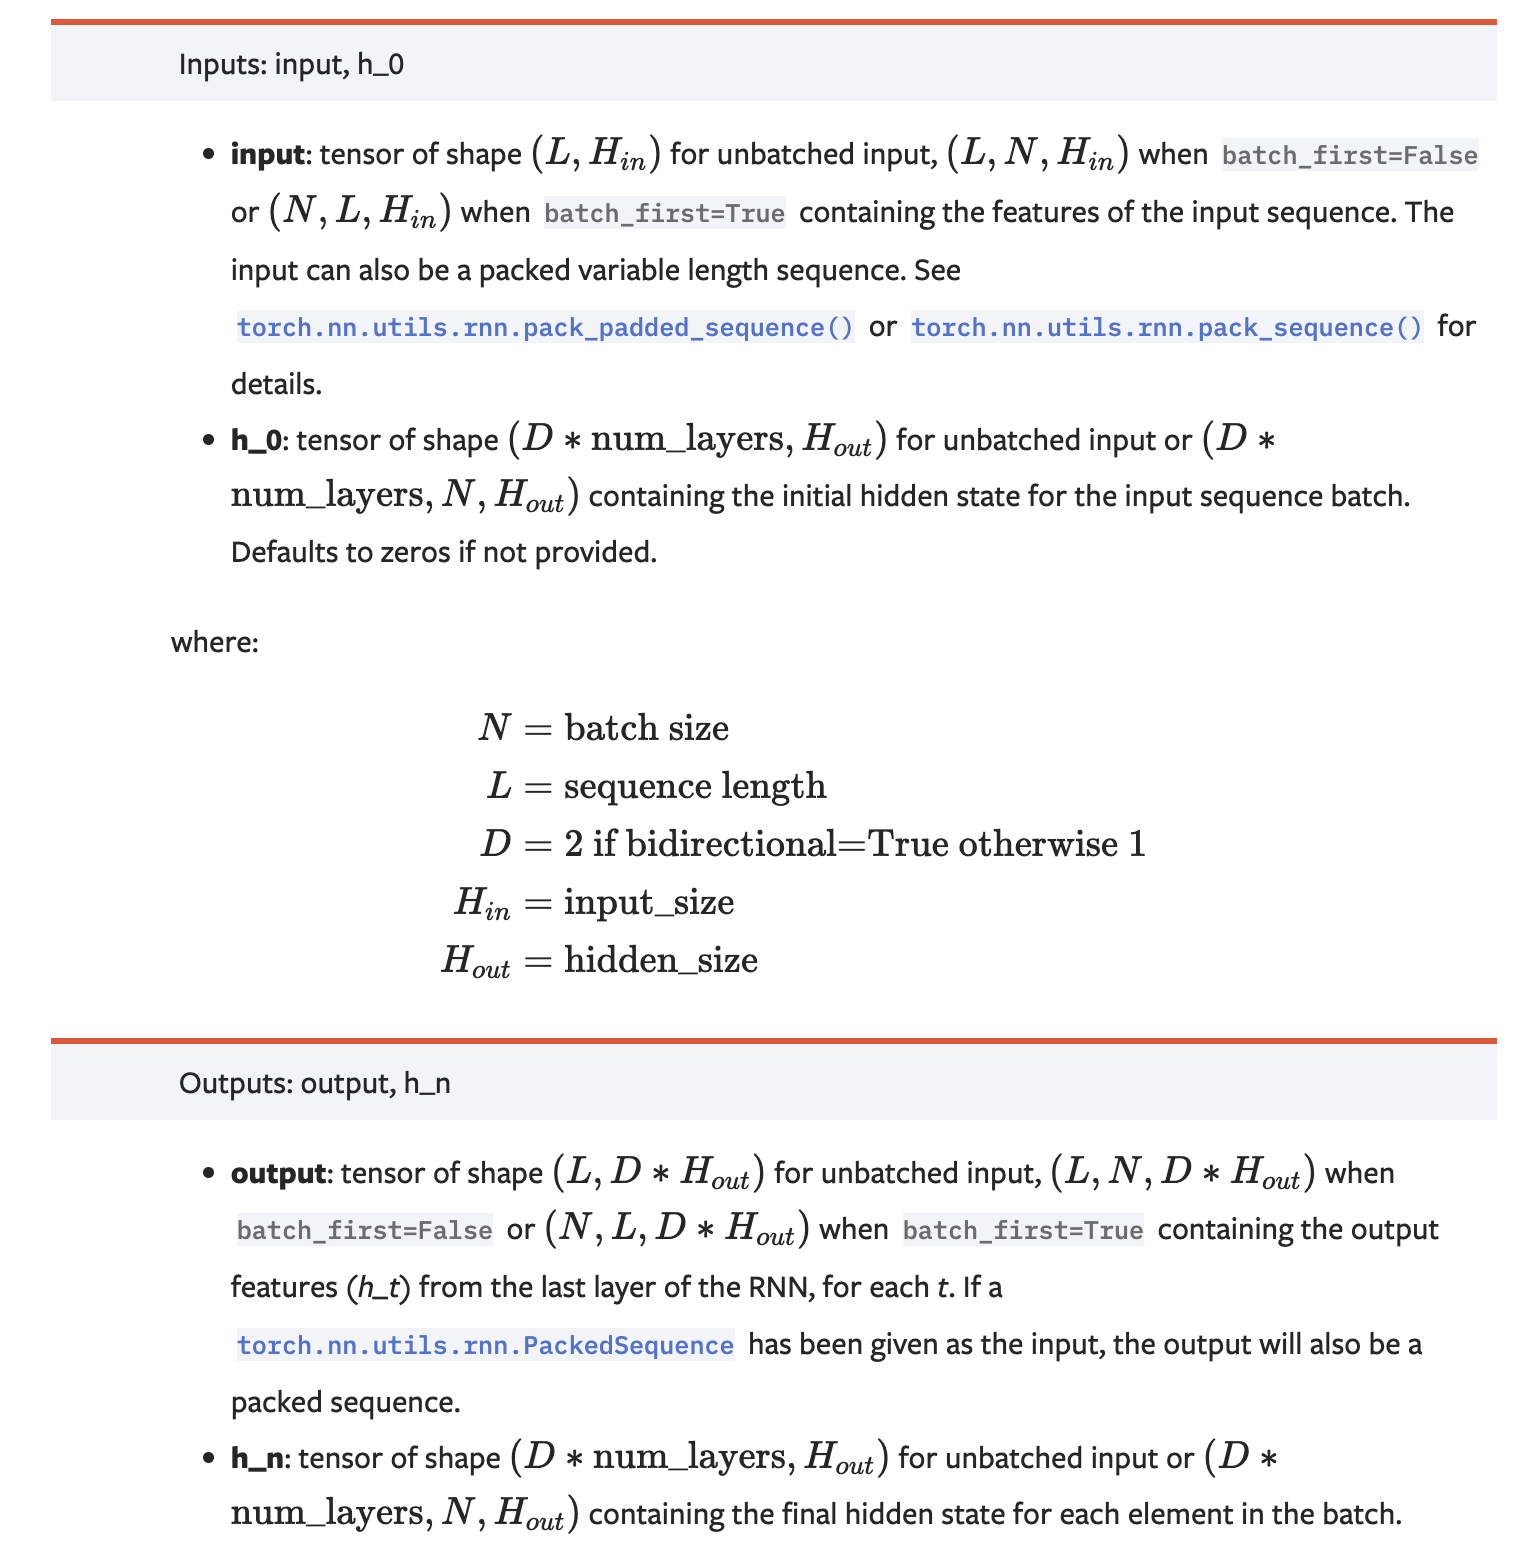

In [6]:
Image(filename='./data/RNN_inout.png')

In [7]:
Image(filename='./data/RNN_principle4.png')

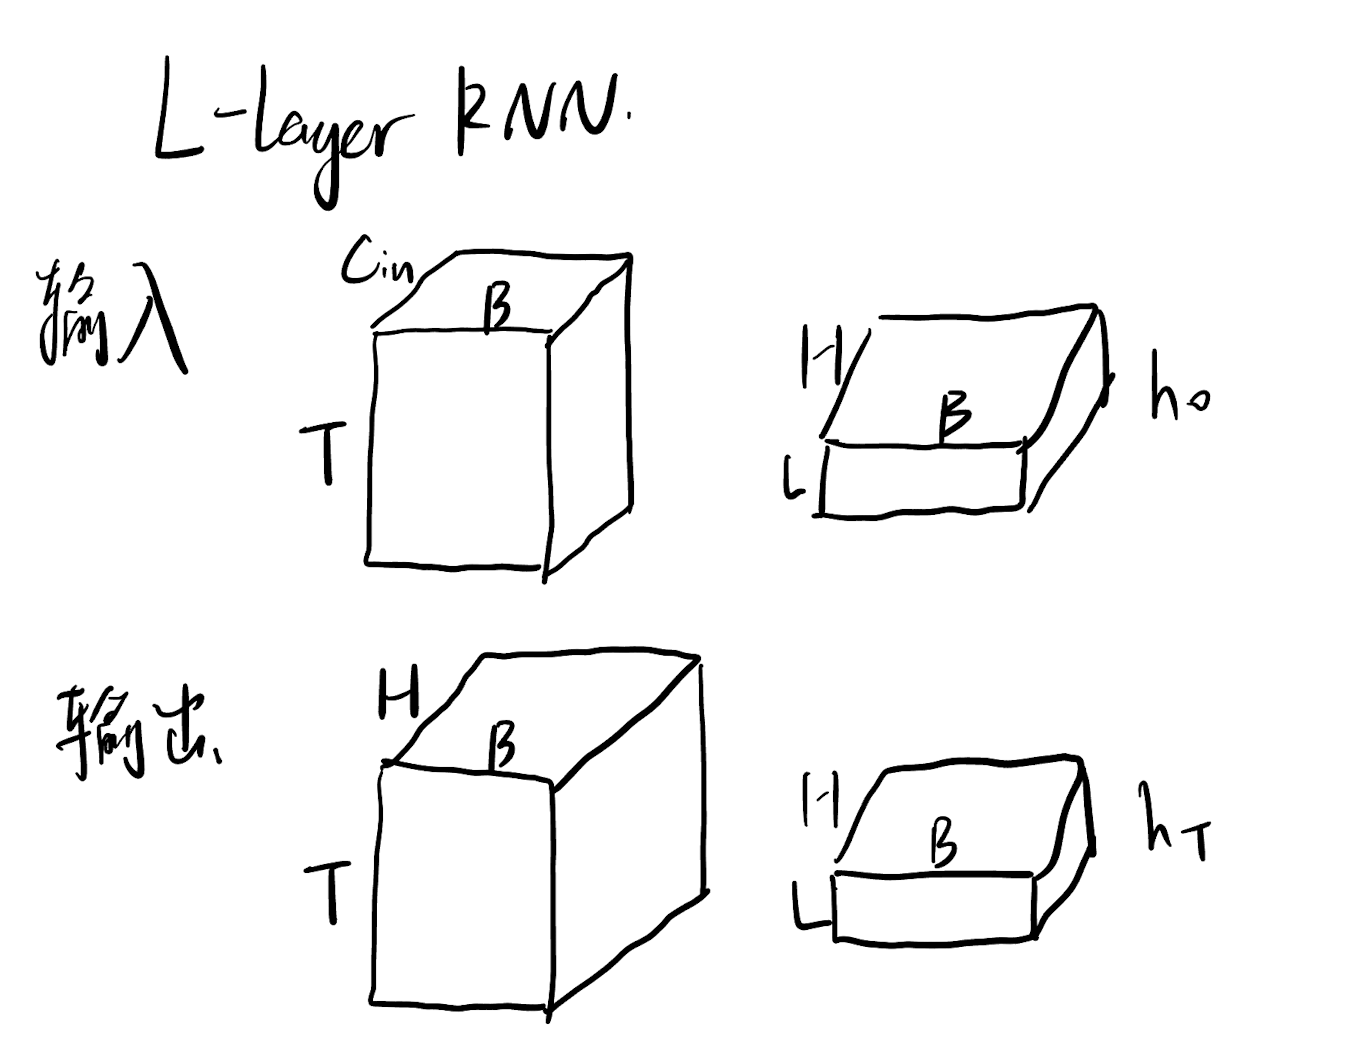

In [9]:
Image(filename='./data/RNN_principle3.png')

In [12]:
Image(filename='./data/RNN_principle1.png')

注意到nn.RNN中，8.4.6式的计算是默认不进行的

In [11]:
Image(filename='./data/RNN_principle2.png')

In [215]:
BATCH_SIZE = 64    # 每个批次的大小，也就是每个批次中包含的样本数量
num_sample = 1000  # 总体样本数量
num_epochs = 100
input_size = 40  # 样本特征数d
seq_len = 30  # 每个样本的时间步数
hidden_size = 128  # 隐藏层的特征数h
output_size = 1  # 输出特征数

# 生成随机数，代表数据
raw_data = torch.randn(seq_len, num_sample, input_size)  # 最原始的样本，形状为(时间步数, 样本数量, 样本特征数)

# 通过将样本向前平移一个时间步shift(-1)，生成标签target，e.g. 代表每支股票在每个时间节点的收益率
target = torch.randn(seq_len, num_sample, 1)

# 调整数据格式，将样本数量调整到第一个轴，方便后续操作。需要输入到DataLoader中的样本，形状为(样本数量, 时间步数, 样本特征数)
data = raw_data.permute(1, 0, 2)
target = target.permute(1, 0, 2)

# 先转换成 torch 能识别的 Dataset
torch_dataset = TensorDataset(data, target)

# 将数据切分为训练集和测试集
train_size = int(0.8 * data.shape[0])
test_size = data.shape[0] - train_size
# random_split函数的输入是一个TensorDataset类型的对象
# 其中包含输入张量和对应的标签张量。输入张量的形状是(num_samples, input_size)
# 其中num_samples是样本数量，input_size是输入特征的维度
trainset, testset = random_split(torch_dataset, [train_size, test_size])


# 把训练集放入DataLoader
# 注意需要指定输入张量的哪个维度代表样本，默认情况下，DataLoader假定输入张量的第一个维度代表样本。
# 自行指定哪个维度是样本很麻烦！所以我们就按照第一个维度为样本调整数据格式
# 上面的data就是已经调整好的样本
# DataLoader中每个batch的形状为(batch_size, seq_len, feature_nums)，即(批量大小，时间步数，每个样本的特征数量)
# 注意测试集无需放入loader中

trainloader = DataLoader(
    dataset=trainset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2)              # 多线程来读数据

for x in trainloader:
    x_batch = x[0]
    y_batch = x[1]
    train_data_shape_of_one_batch = x[0].shape
    label_shape_of_one_batch = x[1].shape
    break

# 查看数据结构
print(f'random_split生成的训练集的长度为{len(trainset)}，测试集的长度为{len(testset)}')
print(f'random_split生成的训练集的第一个样本的形状为{trainset[0][0].shape}')
print(f'random_split生成的训练集的第一个标签的形状为{trainset[0][1].shape}')
print(f'训练集中总共生成{len(trainloader)}个批量的数据，每个批量都包含{BATCH_SIZE}个样本(除了最后一个batch)')
print(f'每个训练集的小批量中，自变量的形状为{train_data_shape_of_one_batch}')
print(f'每个训练集的小批量中，标签的形状为{label_shape_of_one_batch}')

random_split生成的训练集的长度为800，测试集的长度为200
random_split生成的训练集的第一个样本的形状为torch.Size([30, 40])
random_split生成的训练集的第一个标签的形状为torch.Size([30, 1])
训练集中总共生成13个批量的数据，每个批量都包含64个样本(除了最后一个batch)
每个训练集的小批量中，自变量的形状为torch.Size([64, 30, 40])
每个训练集的小批量中，标签的形状为torch.Size([64, 30, 1])


In [59]:
X_train_batch, y_train_batch = next(iter(trainloader))
# (batch_size, seq_len, input_size)
X_train_batch.shape, y_train_batch.shape

(torch.Size([64, 30, 40]), torch.Size([64, 30, 40]))

In [54]:
# 说明一下torch.cat的用法
a = torch.arange(6).reshape(2, 3)
b = torch.arange(8).reshape(2, 4)
# 横向拼接
a, b, torch.cat((a, b), 1)

(tensor([[0, 1, 2],
         [3, 4, 5]]),
 tensor([[0, 1, 2, 3],
         [4, 5, 6, 7]]),
 tensor([[0, 1, 2, 0, 1, 2, 3],
         [3, 4, 5, 4, 5, 6, 7]]))

## 详细的从零开始的RNN网络

### 定义RNN模型

In [256]:
class RNN(nn.Module):
    # 这个模型模拟一个时间步的输出
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input_tensor, hidden_tensor=None):
        # 对一个时间步input_tensor: (batch_size, input_size)，即(batch_size, feature_size)
        # hidden_tensor: (batch_size, hideen_size)
        if hidden_tensor is None:
            hidden_tensor = torch.zeros(input_tensor.size(0), self.hidden_size)
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)  # (batch_size, hidden_size)
        output = self.i2o(combined)  # (batch_size, output_size)
        # 表示每个时间步返回的结果，分别为输出output和隐状态hidden
        return output, hidden
rnn = RNN(input_size, hidden_size, output_size).to(device)

### 损失函数和优化器

In [310]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = nn.MSELoss()
optim = torch.optim.Adam(rnn.parameters(), lr=0.01)

### 模型训练

In [271]:
# 训练num_epochs=100个周期，每次训练周期都遍历了一遍全样本，相当于遍历了100次全样本
for epoch in range(num_epochs):  
    # 每个训练周期都对每个批量进行遍历，总共有16个批量，每个批量的大小为64，则遍历16次
    for inputs, targets in trainloader:  
        # (batch_size, seq_len, input_size)
        # 这里代表每个(batch_size, hidden_size)
        hidden = torch.zeros(inputs.size(0), hidden_size).to(device)
        optimizer.zero_grad()
        # 这步通过不断更新隐状态hidden实现RNN的核心：循环，循环次数为时间步数seq_len，在初始化样本的时候给定
        for i in range(inputs.size(1)):
            # inputs[:, i, :]代表一个时间步的输入
            output, hidden = rnn(inputs[:, i, :], hidden)

        # targets本身是将inputs按照时间步平移一个单位，targets[:, -1, :]代表我们用当前的时间步最后输出的Ot，预测下一个数据。
        # 对于每个小批量，都会计算出一个loss，进行一次梯度下降
        # targets[:, -1, :]带代表最后一个时间步的标签
        l = loss(output, targets[:, -1, :])
        l.backward()
        optim.step()
    
    # 每10个训练周期输出一次结果
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {l.item():.4f}')

# 测试模型
# 序列到类别模式，并且假设测试集已按照时间顺序，而且初始隐状态为0。
# 可以建模使用股票一段时间的历史数据预测今天股票的收益率
with torch.no_grad():
    test_loss = 0
    for input, target in testset:
        # input: 代表单个样本(seq_len, input_size)
        
        for i in range(input.unsqueeze(0).size(1)):  # 遍历时间步
            # input.unsqueeze(0)[:, i, :]: (batch_size, seq_len)
            hidden = torch.zeros(input.unsqueeze(0).size(0), hidden_size)
            output, hidden = rnn(input.unsqueeze(0)[:, i, :], hidden)
            # print(output)
        # 测试集上的误差
        # target[-1]代表最后一个时间步的结果
        test_loss += loss(output, target[-1])
        
    print(f'Test Loss: {test_loss.item():.4f}')



Epoch [10/100], Loss: 1.1373
Epoch [20/100], Loss: 0.8575
Epoch [30/100], Loss: 0.8799
Epoch [40/100], Loss: 1.0073
Epoch [50/100], Loss: 0.9231
Epoch [60/100], Loss: 0.9187
Epoch [70/100], Loss: 1.3394
Epoch [80/100], Loss: 0.8703
Epoch [90/100], Loss: 1.2427
Epoch [100/100], Loss: 1.1696
Test Loss: 220.9221


## 使用nn.RNN简洁实现

### 定义RNN模型

In [301]:
import torch
import torch.nn as nn

# 定义RNN模型
class RNN(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size,
                 num_layers: int=1,
                 nonlinearity: str='tanh',
                 bias: bool=True,
                 batch_first: bool=False,
                 dropout: float=0,
                 bidirectional: bool=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          nonlinearity=nonlinearity,
                          bias=bias,
                          batch_first=batch_first,
                          dropout=dropout,
                          bidirectional=bidirectional)
        # 如果使用这步，我们就可以自己指定输出的形状，实现d2l(8.4.6)式
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor, hidden_tensor: torch.tensor=None):
        # 不提供hidden_tensor，则默认为hidden_tensor为zero tensor
        out, hidden_tensor = self.rnn(input_tensor, hidden_tensor)
        out = self.fc(out)
        return out, hidden_tensor
    
rnn = RNN(input_size=input_size, hidden_size=hidden_size, output_size=1)

### 查看一下shape

In [291]:
inputs, targets  = next(iter(trainloader))

In [292]:
inputs = inputs.permute(1, 0, 2)  # (seq_len, batch_size, input_size)
targets = targets.permute(1, 0, 2)
inputs.shape, targets.shape

(torch.Size([30, 64, 40]), torch.Size([30, 64, 1]))

In [325]:
# RNN模型的默认输出形状为(时间步数, 批量大小，隐藏层单元数)
nn.RNN(input_size=40, hidden_size=128)(inputs)[0].shape, \
nn.RNN(input_size=40, hidden_size=128)(inputs)[1].shape

(torch.Size([30, 32, 128]), torch.Size([1, 32, 128]))

In [300]:
rnn = RNN(input_size=40, hidden_size=128, output_size=1)
output_shape = rnn(inputs)[0].shape
print(f'在我们的RNN模型中的每一个batch训练时，输入RNN的x_batch形状为{batch_x.shape}，代表(时间步数, 批量大小, 样本特征数)\n'
      f'因为本示例数据中，标签形状为{batch_y.shape}，代表每个时间点的每个样本都对应一个标量的标签，\n'
      f'则我们想要RNN模型的输出形状等于标签形状，'
      f'这样就相当于对标签进行了预测。我们设定为output_size={output_size}，\n此时RNN模型输出形状为{output_shape}。')

在我们的RNN模型中的每一个batch训练时，输入RNN的x_batch形状为torch.Size([30, 64, 40])，代表(时间步数, 批量大小, 样本特征数)
因为本示例数据中，标签形状为torch.Size([30, 64, 1])，代表每个时间点的每个样本都对应一个标量的标签，
则我们想要RNN模型的输出形状等于标签形状，这样就相当于对标签进行了预测。我们设定为output_size=1，
此时RNN模型输出形状为torch.Size([30, 64, 1])。


### 损失函数和优化器

In [320]:
optim = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss = nn.MSELoss()

### 训练模型

Epoch [10/300], Loss: 0.8741
Epoch [20/300], Loss: 0.8971
Epoch [30/300], Loss: 0.9560
Epoch [40/300], Loss: 1.0280
Epoch [50/300], Loss: 1.0422
Epoch [60/300], Loss: 0.9863
Epoch [70/300], Loss: 0.9971
Epoch [80/300], Loss: 0.8785
Epoch [90/300], Loss: 1.0862
Epoch [100/300], Loss: 1.0048
Epoch [110/300], Loss: 1.0082
Epoch [120/300], Loss: 0.9713
Epoch [130/300], Loss: 0.9859
Epoch [140/300], Loss: 0.9465
Epoch [150/300], Loss: 1.0283
Epoch [160/300], Loss: 1.0209
Epoch [170/300], Loss: 1.0305
Epoch [180/300], Loss: 0.9262
Epoch [190/300], Loss: 0.8996
Epoch [200/300], Loss: 0.9678
Epoch [210/300], Loss: 1.0906
Epoch [220/300], Loss: 0.9513
Epoch [230/300], Loss: 0.9987
Epoch [240/300], Loss: 1.0000
Epoch [250/300], Loss: 1.0177
Epoch [260/300], Loss: 1.0527
Epoch [270/300], Loss: 1.0290
Epoch [280/300], Loss: 0.9537
Epoch [290/300], Loss: 1.1618
Epoch [300/300], Loss: 1.0905


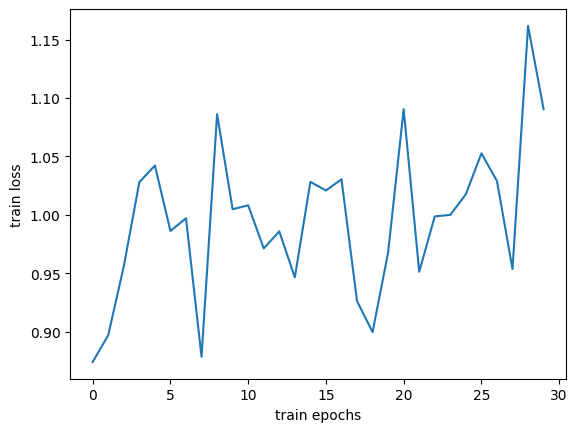

In [322]:
# 定义超参数
learning_rate = 0.01
num_epochs = 300

# 训练模型
idx = 0
loss_list = []
for epoch in range(num_epochs):  
    for inputs, targets in trainloader:  # 每一步 loader 释放一小批数据用来学习
        # 每次输入RNN的参数形状需要为(seq_len, batch, input_size)
        inputs = inputs.permute(1, 0, 2)
        targets = targets.permute(1, 0, 2)
        # optimizer.zero_grad()的作用是将模型的所有参数的梯度值清零。
        # 这个操作通常在每个batch的训练之前调用，以确保每个batch的梯度计算是独立的。
        # 具体来说，optimizer.zero_grad()会遍历模型的所有参数，并将它们的梯度值设为0。
        # 这样做是因为在PyTorch中，梯度是默认会累加的，而不是被替换掉。
        # 因此，在每个batch的训练之前，需要将梯度清零，以确保每个batch的梯度计算是独立的。
        optim.zero_grad()
        
        output_tensor, hidden_tensor = rnn(inputs)
        l = loss(output_tensor, targets)
        l.backward()
        optim.step()
        
    if (epoch + 1) % 10 == 0:
        idx += 1
        loss_list.append(l)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l.item():.4f}")

# with torch.no_grad()是一个上下文管理器，用于禁用梯度计算。
# 在PyTorch中，如果一个张量的requires_grad属性被设置为True，则反向传播时，该张量就会自动求导。
# 但是，在某些情况下，我们不需要计算梯度，例如在模型测试时。这时，我们可以使用with torch.no_grad()来禁用梯度计算，
# 以减少内存的使用并加快代码的运行速度。
# 在with torch.no_grad()代码块中计算得到的张量的requires_grad属性都会被自动设置为False，
# 以避免不必要的内存消耗和计算开销。通常情况下，with torch.no_grad()会在测试模型时使用。
with torch.no_grad():
# plot the train loss     
    plt.plot(np.arange(idx), np.array(loss_list))
    plt.xlabel('train epochs')
    plt.ylabel('train loss')
    plt.show()

### 输出在测试集上的结果

In [321]:
# 每个样本的形状为(时间步数，样本特征数)
# 每个标签的形状也为(时间步数，样本特征数)
print(testset[100][0].shape, testset[100][1].shape)

torch.Size([30, 40]) torch.Size([30, 1])


In [317]:
# RNN模型的默认输出形状为(时间步数, 批量大小，样本特征数)，但是如果输入只有两个维度，那么默认输入为(时间步数，样本特征数)，
# 输出中batch_size这一维度自动消失
s = testset[100][0]
s.shape, rnn(s)[0].shape

(torch.Size([30, 40]), torch.Size([30, 1]))

In [312]:
# 对于每个样本，输出都是一个标量，那么对全体样本的MSEloss的计算方式为：将每个样本的MSEloss相加，然后除以样本数量。
with torch.no_grad():
    l = 0
    for sample, label in testset:
        output, _ = rnn(sample)
        l += loss(output, label)
    l = l / len(testset)
    print(f'Test loss is {l}')

Test loss is 1.118180751800537


## 参考链接

[nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)